# A deep dive into PHA responses

How does the RMF "work"? Well, we start by reading [The Formal Underpinnings of the Response Functions Used in X-Ray Spectral Analysis](https://ui.adsabs.harvard.edu/abs/2001ApJ...548.1010D/abstract), Davis, John E., 2001, ApJ, 548, 1010, where we can take equation 2 and
"forget about" the spatial terms and the time dependence. This gives us

$$
S_p(h) = \int A(\lambda) R(h, \lambda) S(\lambda) d\lambda
$$

where $A$ represents the effective area (ARF) and $R$ the response matrix (RMF). As we switch from the theoretical to the instrumental view we
replace the integral with summations, switch from wavelength to Energy, and using [] rather than () to indicate discrete bins we get

$$
S_p[h] = \sum_i A[E_i] R[E_i, h] S[E_i]
$$

You can (and we do) apply this formula directly, but Sherpa normally does it for you (in part because the RMF on-disk format is designed to save
memory and so complicates the logic).I am going to try and show various ways of implementing this equation, as used by Sherpa.

This notebook **needs** Sherpa 4.16 or later to run. We use the CIAO 4.16 environment as it also requires XSPEC models and they are a pain to build and configure...

In [1]:
import sherpa

sherpa._version.get_versions()

{'date': '2025-09-29T09:22:24-0400',
 'dirty': False,
 'error': None,
 'full-revisionid': '5317ba1bd9c20c5d482e399cdac71d8eb7fde83b',
 'version': '4.18.0.rc1'}

Let's start by reading in a Chandra "imaging mode" (i.e. not a grating observation) response:

In [2]:
from sherpa.astro import io

In [3]:
arf = io.read_arf("9774.arf")
rmf = io.read_rmf("9774.rmf")

In [4]:
arf

<DataARF data set instance '9774.arf'>

It will be useful below to refer to the ARF values:

In [5]:
specresp = arf.get_y()

In [6]:
rmf

<DataRMF data set instance '9774.rmf'>

The ARF is a one-dimensional array but the RMF is a 2D matrix, although stored in a compressed form since most of the data is empty. Let's look at the
RMF as an image, using new-to-4.16 functionality:

In [7]:
from sherpa.astro import instrument

The `rmf_to_image` routine converts a RMF into a `DataIMG` object which we can then display automatically:

In [8]:
instrument.rmf_to_image(rmf)

<DataIMG data set instance '9774.rmf'>

However, `rmf_to_matrix` is more useful here, as it easier to get at the data we care about:

In [9]:
# This returns a RMFMatrix object whih has matrix, channels, and energies fields
rmf_mat = instrument.rmf_to_matrix(rmf)

In [10]:
# What we care about here is the matrix field
rmf_mat.matrix.shape

(1078, 1024)

In [11]:
# It's also useful to get the energy scale
elo, ehi = rmf_mat.energies.grid
emid = (elo + ehi) / 2

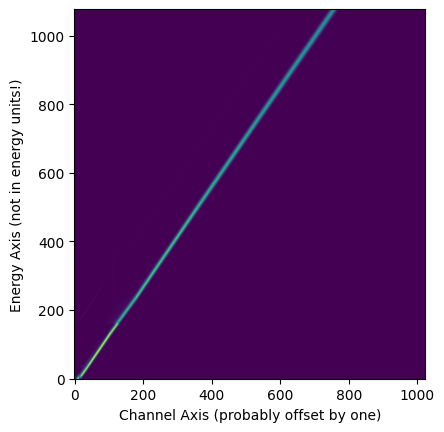

In [12]:
from matplotlib import pyplot as plt

plt.imshow(rmf_mat.matrix, origin='lower')
plt.xlabel("Channel Axis (probably offset by one)")
plt.ylabel("Energy Axis (not in energy units!)");

In [13]:
from sherpa.astro.xspec import XSgaussian

gauss = XSgaussian()
gauss.linee = 3
gauss.sigma = 1

The model can be evaluated directly, and the values depend on the model, but for XSPEC additive models (such as `XSgaussian`)
it creates values of photon per square cm per second:

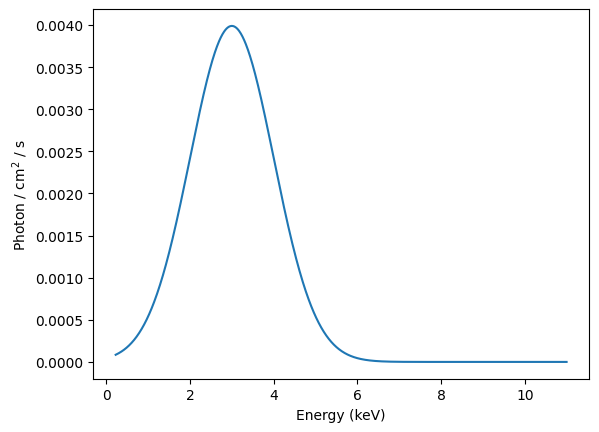

In [14]:
model_raw = gauss(elo, ehi)

plt.plot(emid, model_raw)
plt.xlabel("Energy (keV)")
plt.ylabel("Photon / cm$^2$ / s");

We can "convert" this into a "predicted" spectrum by convoling this with the RMF and mutiplying by the ARF:

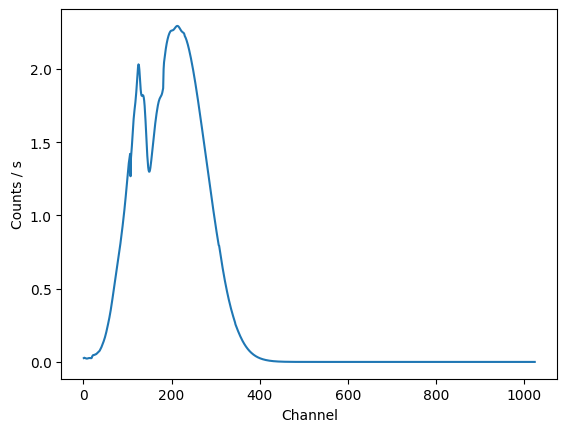

In [15]:
model_pred = (model_raw * specresp) @ rmf_mat.matrix

channels = rmf_mat.channels.grid[0]
plt.plot(channels, model_pred)

plt.xlabel("Channel")
plt.ylabel("Counts / s");

This is direct application of the response, but in Sherpa we hide this with the various classes (`DataARF` and `DataRMF` for representing
the data and `Response1D`, `ARF1d`, `RMF1D` and family to apply these to the models), which can be applied in different situations (the documentation for these
classes is lacking and something we hope to improve in 2024).

We can "apply" the ARF from the `DataARF` (or `ARF1D`) - even though technically this is just simple matrix multiplication:

In [16]:
arf.apply_arf(model_raw)

array([0.00525531, 0.00623099, 0.00729793, ..., 0.        , 0.        ,
       0.        ], shape=(1078,))

This applies to `apply_rmf` to from `DataRMF` (or `RMF1D`):

In [17]:
model_pred2 = rmf.apply_rmf(arf.apply_arf(model_raw))

and we can see that we get almost the same results as the manual result
above (`apply_rmf` applies the sparse matrix rather than use the full matrix used to create `model_raw`);
the numeric values are not the same, but they are close:

In [18]:
(model_pred == model_pred2).all()

np.False_

In [19]:
# The absolute differences are <~ 10^-14
delta = model_pred2 - model_pred
print(delta.min())
print(delta.max())

-6.661338147750939e-15
7.993605777301127e-15


In [20]:
# The percentage differences are <~ 10^-12
pdelta = 100 * delta[model_pred > 0] / model_pred[model_pred > 0]
print(pdelta.min())
print(pdelta.max())

-3.8592894001845593e-13
3.972674642545171e-13


The `apply_xxx` routines require the user sending in model values evaluated on the correct grid. The more Sherpa approach is to include the
response in the model definition. Normally we would include the PHA data (via the `sherpa.astro.instrument.Response1D` factory) but here we shall
use `sherpa.astro.instrument.RSPModelNoPHA`:

In [21]:
model_with_response = instrument.RSPModelNoPHA(arf, rmf, gauss)

This is actually a Sherpa "model", so we can print it out and see the model parameters:

In [22]:
print(model_with_response)

apply_rmf(apply_arf(gaussian))
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   gaussian.LineE thawed            3            0        1e+06        keV
   gaussian.Sigma thawed            1            0           20        keV
   gaussian.norm thawed            1            0        1e+24           


As this model is now "in counts space" we send in the channel array (rather than the energy array used with the `gauss` model):

In [23]:
model_pred3 = model_with_response(channels)

# Note we now compare against model_pred2 not model_pred
(model_pred3 == model_pred2).all()

np.True_

If the above has too much overhead we can get down to the "raw" routine, which for RMF handling is the `sherpa.astro.utils.rmf_fold`
routine **but** this is a very low-level code which we don't guarantee is stable (but it hasn't changed in a *long* time) or well documented.

The `rmf_fold` routine applies the sparse-matrix data to an array (it provides the functionality of the `apply_rmf` method of the `DataRMF`
class). It takes the RMF matrix from the file, after some small tweaking. I am going to read the data in using AstroPy, but you can
also use Crates (the CIAO I/O layer) if you want (the data is the same, the data access is just a bit different):

In [24]:
from astropy.io import fits

hdus = fits.open("9774.rmf")
hdu = hdus[1]  # I know the ordering

In [25]:
hdu.columns

ColDefs(
    name = 'ENERG_LO'; format = 'E'; unit = 'keV'
    name = 'ENERG_HI'; format = 'E'; unit = 'keV'
    name = 'N_GRP'; format = 'I'
    name = 'F_CHAN'; format = 'PI(3)'
    name = 'N_CHAN'; format = 'PI(3)'
    name = 'MATRIX'; format = 'PE(1023)'
)

Here is the data we need:

In [26]:
n_grp = hdu.data["N_GRP"]
f_chan = hdu.data["F_CHAN"]
n_chan = hdu.data["N_CHAN"]
matrix = hdu.data["MATRIX"]

However, as hinted by the format settings in the `ColDefs` output above, RMF files play games and the data can be stored as "variable length arrays",
which means each row can have a different length - this is used for the `F_CHAN`, `N_CHAN`, and `MATRIX` blocks above - which means the overall array has a "object" datatype, even though each row has the correct data type.

In [27]:
n_chan.dtype

dtype('O')

In [28]:
n_chan[0], n_chan[-1]

(array([27], dtype=int16), array([46, 46, 58], dtype=int16))

We also need some other metadata (the number of channels and the "starting point" of the channel array):

In [29]:
detchans = hdu.header["DETCHANS"]
detchans

1024

In [30]:
# This requires knowing the FITS file structure
offset = hdu.header["TLMIN4"]
offset

1

In [31]:
from sherpa.astro.utils import rmf_fold

As mentioned, `rmf_fold` is low-level code and doesn't provide many safety checks. So, for instance, if you were to
try to run

    rmf_fold(model_raw, n_grp, f_chan, n_chan, matrix, detchans, offset)

you'd find the code would crash the interpreter. We need to "flatten out" the data into a form that `rmf_fold` understands
(and is currently poorly documented).

Now, the `N_GRP` column lists the number of elements in each row (at least for `F_CHAN` and `N_CHAN` columns) and this data may be stored as 
a normal array rather than the variable-length approach used here - that is each column is a 2D matrix - so we would need to remove the 0 elements.

The following will hopefully be sufficient but is not optimised (but it only needs to be done when reading in the data from the RMF):

In [32]:
fchans = []
nchans = []
for ng, fc, nc in zip(n_grp, f_chan, n_chan):
    if ng == 0:
        # some files have this
        continue

    fchans.append(fc[:ng])
    nchans.append(nc[:ng])

In [33]:
import numpy as np

fchan_clean = np.concatenate(fchans)
nchan_clean = np.concatenate(nchans)

# I don't think we have to do anything special with the matrix, but I can not guarantee that
matrix_clean = np.concatenate(matrix)

In [34]:
model_pred4 = rmf_fold(model_raw * specresp, n_grp, fchan_clean, nchan_clean, matrix_clean, detchans, offset)

# Note we now compare against model_pred2 not model_pred
(model_pred4 == model_pred2).all()

np.True_

Rather than doing this yourself you can use `io.read_rmf` and then use the RMF fields directly since

In [35]:
(rmf.n_grp == n_grp).all(), (rmf.f_chan == fchan_clean).all(), (rmf.n_chan == nchan_clean).all(), (rmf.matrix == matrix_clean).all() 

(np.True_, np.True_, np.True_, np.True_)

It is interesting to see what the different approaches "cost". Hwever, it's not a fair comparison as the different approaches do not
provide the same functionality, and you also have to be careful in interpreting the results as Sherpa does some model caching **and**
you have to be careful with data types (e.g.`model_pred4` is the slowest version but can become the fastest if you fix the ndarray
data types):

In [37]:
# Let's try to turn off the model cache on the gauss model
gauss.cache = 0

In [38]:
# model_pred
%timeit (model_raw * specresp) @ rmf_mat.matrix

159 μs ± 9.87 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [39]:
# model_pred2
%timeit rmf.apply_rmf(arf.apply_arf(model_raw))

330 μs ± 11.7 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [40]:
# model_pred3
%timeit model_with_response(channels)

330 μs ± 3.36 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [41]:
# model_pred4
%timeit rmf_fold(model_raw * specresp, n_grp, fchan_clean, nchan_clean, matrix_clean, detchans, offset)

518 μs ± 15.9 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Some of it comes down to data types, as the `rmf_fold` code needs to convert the types to send to the C++ code. Switching
to more-appropriate types does make a difference, and at least gets it below the times for `model_pred3` and `model_pred4`:

In [42]:
n_grp.dtype, fchan_clean.dtype, nchan_clean.dtype, matrix_clean.dtype

(dtype('>i2'), dtype('int16'), dtype('int16'), dtype('float32'))

In [43]:
n_grp2 = n_grp.astype(np.int64)
fchan_clean2 = fchan_clean.astype(np.int64)
nchan_clean2 = nchan_clean.astype(np.int64)
matrix_clean2 = matrix_clean.astype(np.float64)

In [44]:
%timeit rmf_fold(model_raw * specresp, n_grp2, fchan_clean2, nchan_clean2, matrix_clean2, detchans, offset)

305 μs ± 7.84 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


I just want to check that this does give the desired results:

In [45]:
model_pred5 = rmf_fold(model_raw * specresp, n_grp2, fchan_clean2, nchan_clean2, matrix_clean2, detchans, offset)

# Note we now compare against model_pred2 not model_pred
(model_pred5 == model_pred2).all()

np.True_

So the moral may be that using the actual RMF matrix, rather than the compressed one, may be faster, but it depends on the matrix **and**
it may lead to extra memory use since the compressed form is only about 40% of the matrix in this case:

In [46]:
matrix_clean2.size / rmf_mat.matrix.size

0.3972217793367347

As a final warning, as you delve deeper into the Sherpa internals the more likelihood to come across interfaces that will be changed across versions!